In [14]:
import sys
sys.path.append('/auto/home/filya/3DMolGen')
import os
import os.path as osp
import numpy as np
import datamol as dm
from rdkit import Chem
import ast
from loguru import logger as log
from tqdm import tqdm  
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

from molgen3D.data_processing.preprocessing_forked_ET_Flow import load_pkl, load_json, embed_coordinates, embed_coordinates_spherical
from molgen3D.evaluation.inference import parse_molecule_with_coordinates
from get_cartesian_from_spherical import parse_molecule_with_spherical_coordinates

embedding_func_selector = {
    "cartesian": embed_coordinates,
    "spherical": embed_coordinates_spherical
}
decoding_func_selector = {
    "cartesian": parse_molecule_with_coordinates,
    "spherical": parse_molecule_with_spherical_coordinates
}

def validate(raw_path, embedding_type, limit, precision, single = False, cur_id = -1): #dest_folder_path, indices_path,
    partitions = ["qm9"]
    rmsds = []
    embedding_function = embedding_func_selector[embedding_type]
    decoding_function = decoding_func_selector[embedding_type]
    if not os.path.exists("molecules"):
        os.makedirs("molecules")
    writer = Chem.SDWriter("molecules/special_mol.sdf")
    writer1 = Chem.SDWriter("molecules/special-rec.sdf")
    writer_error = Chem.SDWriter("molecules/error.sdf")

    for partition in partitions:
        # dest_path = osp.join(dest_folder_path, partition.upper())
        # train_indices = set(sorted(np.load(osp.join(*[indices_path, partition.upper(),
        #                                                 "train_indices.npy"]), allow_pickle=True)))
        # val_indices = set(sorted(np.load(osp.join(*[indices_path, partition.upper(),
        #                                             "val_indices.npy"]), allow_pickle=True)))
        # log.info(f"{partition} indices contain train:{len(train_indices)}, valid:{len(val_indices)},"\
        #             f" total:{len(train_indices)+len(val_indices)} samples")
        mols = load_json(osp.join(raw_path, f"summary_{partition}.json"))
        for id, (mol_id, mol_dict) in tqdm(
            enumerate(mols.items()),
            total=len(mols),
            desc=f"Processing molecules of {partition}",
        ):
            if id >= limit:
                break
            mol_pickle = load_pkl(os.path.join(raw_path, mol_dict["pickle_path"]))
            confs = mol_pickle["conformers"]    
            if single and id != cur_id:
                continue   
            try: 
                for conf in confs:
                    mol, geom_id = conf["rd_mol"], conf["geom_id"]
                    canonical_smiles = dm.to_smiles(
                        mol,
                        canonical=True,
                        explicit_hs=True,
                        with_atom_indices=False,
                        isomeric=False,
                    )
                    if '.' in canonical_smiles:
                        continue
                    atom_order = list(map(int, ast.literal_eval(mol.GetProp('_smilesAtomOutputOrder'))))
                    embedded_smiles = embedding_function(mol, canonical_smiles, atom_order, precision)
                    
                    # sample = {"canonical_smiles": canonical_smiles,
                    #             "geom_embed_coordinatesid": geom_id, 
                    #             "embedded_smiles": embedded_smiles}
                    mol1 = decoding_function(embedded_smiles)
                    rmsd = AllChem.GetBestRMS(mol, mol1)
                    rmsds.append(rmsd)
                    if rmsd > 1:
                        # writer.write(mol)
                        # writer1.write(mol1)
                        # log.info(canonical_smiles)
                        # log.info(len(confs))
                        # log.info(id)
                        log.info(rmsd)

            except Exception as e:
                log.error(f"Error: {e} for molecule {canonical_smiles}, id {id}")
                writer_error.write(mol)
    
    writer.close()
    writer1.close()
    writer_error.close()
    
    rmsds = np.array(rmsds)
    return rmsds

def stat_log(rmsds):
    max_rmsd = np.max(rmsds)
    mean_rmsd = np.mean(rmsds)
    percentile95 = np.percentile(rmsds, 95)
    log.info(f"Maximum RMSD: {max_rmsd}")
    log.info(f"Mean RMSD: {mean_rmsd}")
    log.info(f"95th Percentile: {percentile95}")
    plt.figure(figsize=(8, 6))
    plt.hist(rmsds, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("RMSD")
    plt.ylabel("Frequency")
    plt.title("Distribution of RMSDs")
    plt.show()
    print(np.sort(rmsds)[::-1])


Processing molecules of qm9:   0%|          | 0/133258 [00:00<?, ?it/s]2025-03-10 15:12:22.081 | ERROR    | __main__:validate:88 - Error: ('f,c1,i are collinear in atom', 0) for molecule [H][C]#[C][H], id 1
2025-03-10 15:12:22.084 | ERROR    | __main__:validate:88 - Error: ('f,c1,i are collinear in atom', 0) for molecule [H][C]#[C][C]#[C][H], id 3
Processing molecules of qm9:   1%|          | 1000/133258 [00:36<1:20:24, 27.41it/s]
2025-03-10 15:12:58.578 | INFO     | __main__:stat_log:102 - Maximum RMSD: 1.569665950762992
2025-03-10 15:12:58.578 | INFO     | __main__:stat_log:103 - Mean RMSD: 0.0003999931770684102
2025-03-10 15:12:58.579 | INFO     | __main__:stat_log:104 - 95th Percentile: 0.0003836558533474881


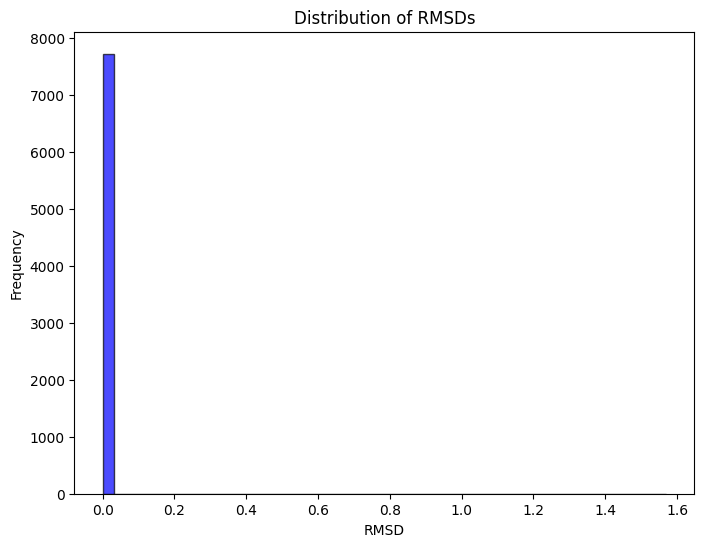

In [12]:
# Parameters for preprocessing
raw_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder"
# dest_folder_path = "geom"
# os.makedirs(dest_folder_path, exist_ok=True)
# indices_path = "/mnt/sxtn2/chem/GEOM_data/et_flow_indice/"
embedding_type = "spherical"
limit = 1000

# rmsds = validate(raw_path, embedding_type, limit, precision=4, single=True, cur_id=994) # dest_folder_path, indices_path
rmsds = validate(raw_path, embedding_type, limit, precision=4)
stat_log(rmsds)

Processing molecules of qm9:   0%|          | 0/133258 [00:00<?, ?it/s]2025-03-06 18:07:47.052 | ERROR    | get_spherical_from_cartesian:calculate_descriptors:188 - f,c1,i are collinear in atom
2025-03-06 18:07:47.052 | ERROR    | get_spherical_from_cartesian:calculate_descriptors:185 - c2 was not found for atom 3, 3
2025-03-06 18:07:47.053 | ERROR    | get_spherical_from_cartesian:calculate_descriptors:188 - f,c1,i are collinear in atom
2025-03-06 18:07:47.054 | INFO     | __main__:validate:79 - [H][C]#[C][H]
2025-03-06 18:07:47.054 | INFO     | __main__:validate:81 - 1
2025-03-06 18:07:47.055 | INFO     | __main__:validate:82 - 1.193788910686811
2025-03-06 18:07:47.056 | ERROR    | get_spherical_from_cartesian:calculate_descriptors:188 - f,c1,i are collinear in atom
2025-03-06 18:07:47.056 | ERROR    | get_spherical_from_cartesian:calculate_descriptors:185 - c2 was not found for atom 0, 3
2025-03-06 18:07:47.059 | ERROR    | get_spherical_from_cartesian:calculate_descriptors:188 - f,

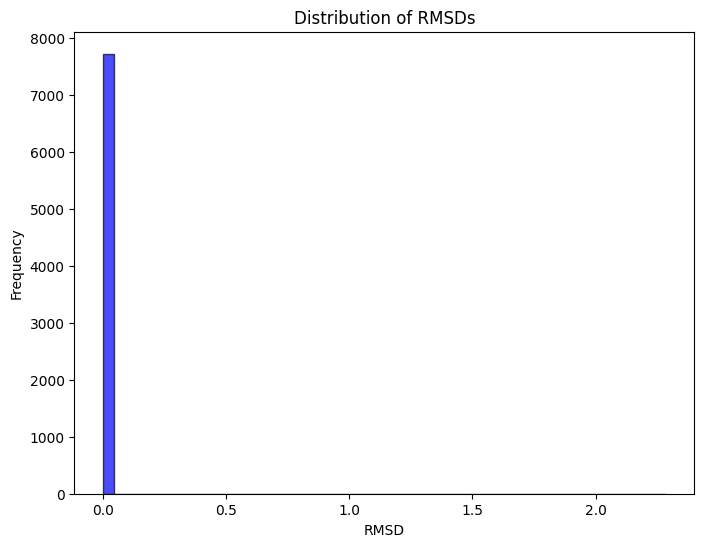

In [ ]:
import numpy as np

# Parameters for preprocessing
raw_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder"
# dest_folder_path = "geom"
# os.makedirs(dest_folder_path, exist_ok=True)
# indices_path = "/mnt/sxtn2/chem/GEOM_data/et_flow_indice/"
embedding_type = "spherical"
limit = 1000

# rmsds = validate(raw_path, embedding_type, limit, precision=4, single=True, cur_id=994) # dest_folder_path, indices_path
rmsds = validate(raw_path, embedding_type, limit, precision=4)
stat_log(rmsds)

In [1]:
# Parameters for preprocessing
raw_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder"
dest_folder_path = "geom"
os.makedirs(dest_folder_path, exist_ok=True)

indices_path = "/mnt/sxtn2/chem/GEOM_data/et_flow_indice/"
embedding_type = "spherical"
limit = 100

rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=4)

stat_log(rmsds)

NameError: name 'os' is not defined

In [2]:
stat_log(rmsds) #c4

NameError: name 'stat_log' is not defined

Processing molecules of qm9:   1%|          | 745/133258 [00:02<09:22, 235.69it/s]

[H][C]#[C][C](=[O])[N]=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)N=C=O.N#N


Processing molecules of qm9:   1%|          | 949/133258 [00:03<09:50, 223.94it/s][18:10:09] Explicit valence for atom # 6 O, 3, is greater than permitted
[18:10:09] Explicit valence for atom # 7 H, 2, is greater than permitted
Processing molecules of qm9:   1%|          | 1050/133258 [00:03<07:13, 304.79it/s]

[H][C]#[C][C](=[O])[C]([H])=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[CH][C][O].N#N
[H][C]#[C][C](=[O])[N]=[C]=[N][H][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[N][C][NH].N#N


Processing molecules of qm9:   2%|▏         | 2092/133258 [00:08<02:43, 800.39it/s][18:10:14] Explicit valence for atom # 7 H, 2, is greater than permitted
[18:10:14] Explicit valence for atom # 0 C, 1, is greater than permitted


[H][C]#[C][C]([H])=[C]([N]=[O])[C]([H])([H])[H][H][N]([H])[C]([H])([H])[H]
Error: Failed to parse the extracted SMILES. for molecule C#CC=C(C)[N][O].CN
[C-4][C-4][C-4][C-4][C-4][C-4][H+][H+][H+][H+][H+][H][C-3][H][C-3][H][C-3]
Error: Failed to parse the extracted SMILES. for molecule C#CCC#CC#CCC


Processing molecules of qm9:   4%|▍         | 5000/133258 [00:49<21:09, 100.99it/s] 

Maximum RMSD: 0.006011901342061139
Mean RMSD: 0.004702777946379792
95th Percentile: 0.005228246823179082


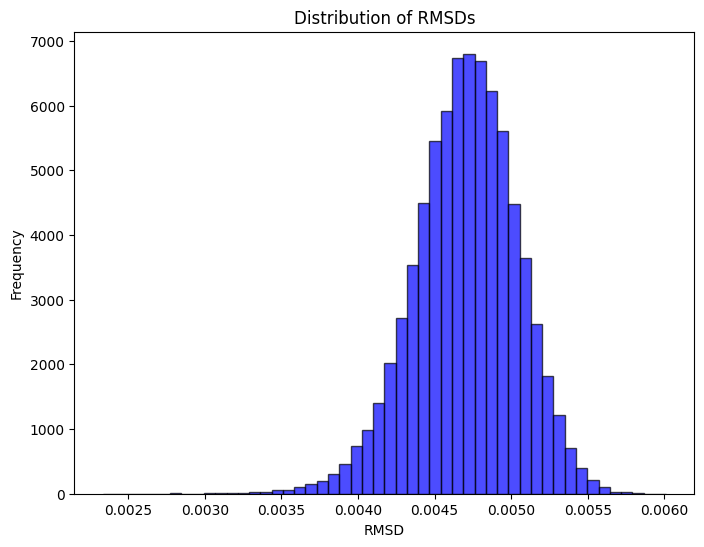

In [9]:
rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=2)
stat_log(rmsds)

Processing molecules of qm9:   1%|          | 753/133258 [00:02<09:02, 244.34it/s]

[H][C]#[C][C](=[O])[N]=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)N=C=O.N#N


Processing molecules of qm9:   1%|          | 912/133258 [00:03<11:26, 192.69it/s][18:11:49] Explicit valence for atom # 6 O, 3, is greater than permitted
[18:11:49] Explicit valence for atom # 7 H, 2, is greater than permitted
Processing molecules of qm9:   1%|          | 1029/133258 [00:03<06:24, 343.91it/s]

[H][C]#[C][C](=[O])[C]([H])=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[CH][C][O].N#N
[H][C]#[C][C](=[O])[N]=[C]=[N][H][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[N][C][NH].N#N


Processing molecules of qm9:   2%|▏         | 2082/133258 [00:07<02:28, 884.49it/s][18:11:54] Explicit valence for atom # 7 H, 2, is greater than permitted
[18:11:54] Explicit valence for atom # 0 C, 1, is greater than permitted


[H][C]#[C][C]([H])=[C]([N]=[O])[C]([H])([H])[H][H][N]([H])[C]([H])([H])[H]
Error: Failed to parse the extracted SMILES. for molecule C#CC=C(C)[N][O].CN
[C-4][C-4][C-4][C-4][C-4][C-4][H+][H+][H+][H+][H+][H][C-3][H][C-3][H][C-3]
Error: Failed to parse the extracted SMILES. for molecule C#CCC#CC#CCC


Processing molecules of qm9:   4%|▍         | 5000/133258 [00:37<15:50, 134.89it/s] 

Maximum RMSD: 6.085108419891015e-06
Mean RMSD: 4.716564828831656e-06
95th Percentile: 5.236215178110685e-06


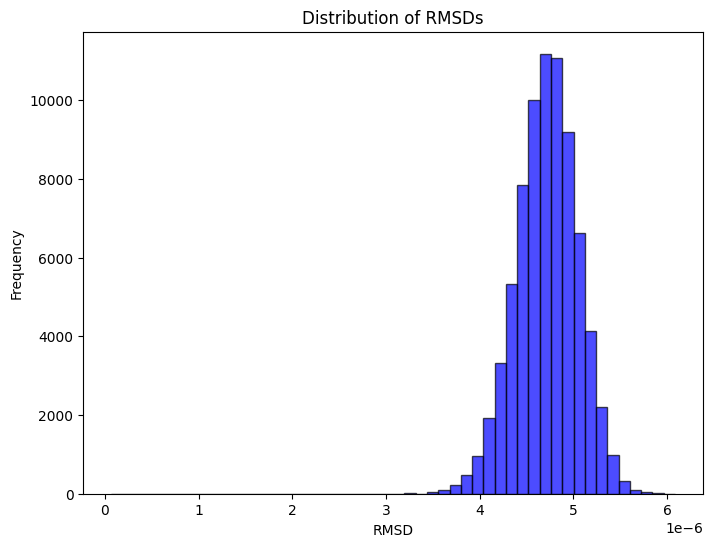

In [10]:
rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=5)
stat_log(rmsds)